In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
    # tf.config.experimental.set_virtual_device_configuration(gpu_devices[0],
    # [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*6)])
else:
    print('Using CPU')

sns.set_style('whitegrid')
np.random.seed(42)

results_path = Path('results', 'sentiment_imdb')
if not results_path.exists():
    results_path.mkdir(parents=True)

Using GPU


In [18]:
# Load Reviews
path = Path('data', 'aclImdb')
files = path.glob('**/*.txt')
len(list(files))

100006

In [19]:
files = path.glob('*/**/*.txt')
outcomes = set()
data = []
for f in files:
    if f.stem.startswith(('urls_', 'imdbEr')):
        continue
    _, _, data_set, outcome = f.parent.as_posix().split('/')
    if outcome == 'unsup':
        continue
    data.append([data_set, int(outcome == 'pos'), f.read_text(encoding='latin1')])

data = pd.DataFrame(data, columns=['dataset', 'label', 'review'])

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   dataset  0 non-null      object
 1   label    0 non-null      object
 2   review   0 non-null      object
dtypes: object(3)
memory usage: 0.0+ bytes


In [5]:
train_data = data.loc[data.dataset=='train', ['label', 'review']]
test_data = data.loc[data.dataset=='test', ['label', 'review']]
train_data.label.value_counts()

0    12500
1    12500
Name: label, dtype: int64

In [25]:
train_data.review.sample(5)

32455    Curiously, Season 6 of the Columbo series cont...
34069    Believe it or not, "The Woodchipper Massacre" ...
46322    This movie is a lot of fun. What makes it grea...
44454    As the first of the TV specials offered on the...
36803    This documentary is at its best when it is sim...
Name: review, dtype: object

In [6]:
test_data.label.value_counts()

0    12500
1    12500
Name: label, dtype: int64

In [7]:
# Tokenizer
num_words = 10000
t = Tokenizer(num_words=num_words, lower=True, oov_token=2)
t.fit_on_texts(train_data.review)
vocab_size = len(t.word_index) + 1
vocab_size

88586

In [36]:
print(t.word_docs)

defaultdict(<class 'int'>, {'with': 17466, 'singers': 62, 'might': 2423, 'just': 10549, 'from': 11715, 'those': 3771, 'putting': 357, 'seem': 1921, 'to': 23475, 'third': 664, 'has': 10065, 'zsigmond': 4, 'even': 8418, 'of': 23726, 'story': 7584, 'level': 870, 'cryptic': 18, 'opening': 891, 'be': 14139, 'it': 21332, 'into': 6424, 'orchestra': 40, 'formal': 24, 'stays': 175, 'who': 11133, 'out': 10612, 'should': 4037, 'narrative': 355, 'an': 12208, 'forrest': 37, 'mob': 131, 'and': 24164, 'absurd': 280, 'stars': 1463, 'man': 3790, 'grader': 24, 'briefly': 133, 'make': 6128, 'feelings': 354, "it's": 9225, 'you': 12888, 'audience': 1766, 'crazy': 572, 'think': 5441, 'too': 5722, 'that': 20041, 'a': 24174, 'future': 757, 'comedy': 2339, 'era': 530, 'violent': 460, 'than': 7121, 'kirkland': 5, 'chantings': 1, 'pig': 78, 'better': 4625, 'dialogue': 1335, 'on': 15710, 'no': 8202, 'the': 24793, 'for': 17882, 'unnatural': 42, 'would': 8043, 'starts': 1073, 'eventually': 663, 'general': 656, 'is'

In [8]:
train_data_encoded = t.texts_to_sequences(train_data.review)
test_data_encoded = t.texts_to_sequences(test_data.review)
max_length = 100

In [9]:
# Pad Sequences
X_train_padded = pad_sequences(train_data_encoded, maxlen=max_length, padding='post', truncating='post')
y_train = train_data['label']
X_train_padded.shape

(25000, 100)

In [39]:
X_train_padded[:5]

array([[  63,    5,    4,  130,   35,   45, 7577, 1415,   16,    4, 4253,
         515,   44,   17,    4,  634,  134,   13,    7,    4, 1302,  460,
           5, 1752,  210,    4,    1, 7694,  309,    7,  677,   81,   33,
        2138, 1111, 3009,   32,    2,  930,    1,    5,   43, 5121,  470,
          10, 2666, 1752,    2,  224,   56,   17,   55,  829, 1319,  848,
         229,   10,   41,   97,  123, 1485,   58,  146,   37,    2,  997,
         142,   28,  677,  123,    2,    1,  412,   60,   95, 2279,  304,
         773,    6,    4,  838,    1,   21,    4, 1756,  647,   43,  126,
          72,   23,  236,  102,   17,   47,   50,  625,   32,  703,   85,
           1],
       [4518,    1,  515,   15,    4, 3418,  160, 8596,    1, 1703,    7,
        4893,   54,   17, 4519, 5675,  139,    1,    6, 1024, 4989, 3051,
        4520,  589, 1340,   35,    7, 1545,   96,    4,  759,    5,    1,
           6,   25, 3514,    9,    1,    5,   10,  110, 3052,    6,    2,
        1068,   15,    

In [10]:
X_test_padded = pad_sequences(test_data_encoded, maxlen=max_length, padding='post', truncating='post')
y_test = test_data['label']
X_test_padded.shape

(25000, 100)

In [11]:
# load the pretrained GloVe embeddings into memory
glove_path = Path('data', 'glove', 'glove.6B.100d.txt')
embeddings_index = dict()

for line in glove_path.open(encoding='latin1'):
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
    except:
        continue
    embeddings_index[word] = coefs
print(f'Loaded {len(embeddings_index):,d} word vectors.')

Loaded 399,883 word vectors.


In [43]:
t.word_index

{2: 1,
 'the': 2,
 'and': 3,
 'a': 4,
 'of': 5,
 'to': 6,
 'is': 7,
 'br': 8,
 'in': 9,
 'it': 10,
 'i': 11,
 'this': 12,
 'that': 13,
 'was': 14,
 'as': 15,
 'for': 16,
 'with': 17,
 'movie': 18,
 'but': 19,
 'film': 20,
 'on': 21,
 'not': 22,
 'you': 23,
 'are': 24,
 'his': 25,
 'have': 26,
 'he': 27,
 'be': 28,
 'one': 29,
 'all': 30,
 'at': 31,
 'by': 32,
 'an': 33,
 'they': 34,
 'who': 35,
 'so': 36,
 'from': 37,
 'like': 38,
 'her': 39,
 'or': 40,
 'just': 41,
 'about': 42,
 "it's": 43,
 'out': 44,
 'has': 45,
 'if': 46,
 'some': 47,
 'there': 48,
 'what': 49,
 'good': 50,
 'more': 51,
 'when': 52,
 'very': 53,
 'up': 54,
 'no': 55,
 'time': 56,
 'she': 57,
 'even': 58,
 'my': 59,
 'would': 60,
 'which': 61,
 'only': 62,
 'story': 63,
 'really': 64,
 'see': 65,
 'their': 66,
 'had': 67,
 'can': 68,
 'were': 69,
 'me': 70,
 'well': 71,
 'than': 72,
 'we': 73,
 'much': 74,
 'been': 75,
 'bad': 76,
 'get': 77,
 'will': 78,
 'do': 79,
 'also': 80,
 'into': 81,
 'people': 82,
 'other'

In [12]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word) # creating embedding matrix by GloVe(pretrained word vectors)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_matrix.shape

(88586, 100)

In [13]:
# Define Model Architecture
embedding_size = 100
rnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim= embedding_size, input_length=max_length,
              weights=[embedding_matrix], trainable=False),
    GRU(units=32,  dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          8858600   
                                                                 
 gru (GRU)                   (None, 32)                12864     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 8,871,497
Trainable params: 12,897
Non-trainable params: 8,858,600
_________________________________________________________________
587/782 [=====================>........] - ETA: 1:07 - loss: 0.6430 - accuracy: 0.6123 - AUC: 0.6678

In [14]:
rnn.compile(loss='binary_crossentropy', optimizer='RMSProp',
            metrics=['accuracy', tf.keras.metrics.AUC(name='AUC')])
rnn_path = (results_path / 'lstm.pretrained.h5').as_posix()

checkpointer = ModelCheckpoint(filepath=rnn_path, verbose=1, monitor='val_AUC', mode='max',
                               save_best_only=True)
early_stopping = EarlyStopping(monitor='val_AUC', patience=5, mode='max', restore_best_weights=True)
training = rnn.fit(X_train_padded, y_train, batch_size=32, epochs=100,
                   validation_data=(X_test_padded, y_test), callbacks=[early_stopping, checkpointer],
                   verbose=1, workers=6)

Epoch 1/100
782/782 [==============================] - ETA: 0s - loss: 0.6143 - accuracy: 0.6452 - AUC: 0.7136
Epoch 00001: val_AUC improved from -inf to 0.83855, saving model to results/sentiment_imdb\lstm.pretrained.h5
782/782 [==============================] - 314s 399ms/step - loss: 0.6143 - accuracy: 0.6452 - AUC: 0.7136 - val_loss: 0.5074 - val_accuracy: 0.7547 - val_AUC: 0.8385
Epoch 2/100
782/782 [==============================] - ETA: 0s - loss: 0.4850 - accuracy: 0.7690 - AUC: 0.8472
Epoch 00002: val_AUC improved from 0.83855 to 0.87378, saving model to results/sentiment_imdb\lstm.pretrained.h5
782/782 [==============================] - 298s 381ms/step - loss: 0.4850 - accuracy: 0.7690 - AUC: 0.8472 - val_loss: 0.4862 - val_accuracy: 0.7567 - val_AUC: 0.8738
Epoch 3/100
782/782 [==============================] - ETA: 0s - loss: 0.4492 - accuracy: 0.7881 - AUC: 0.8708
Epoch 00003: val_AUC improved from 0.87378 to 0.88782, saving model to results/sentiment_imdb\lstm.pretrained.

In [15]:
y_score = rnn.predict(X_test_padded)
roc_auc_score(y_score=y_score.squeeze(), y_true=y_test)

0.9124665056000001

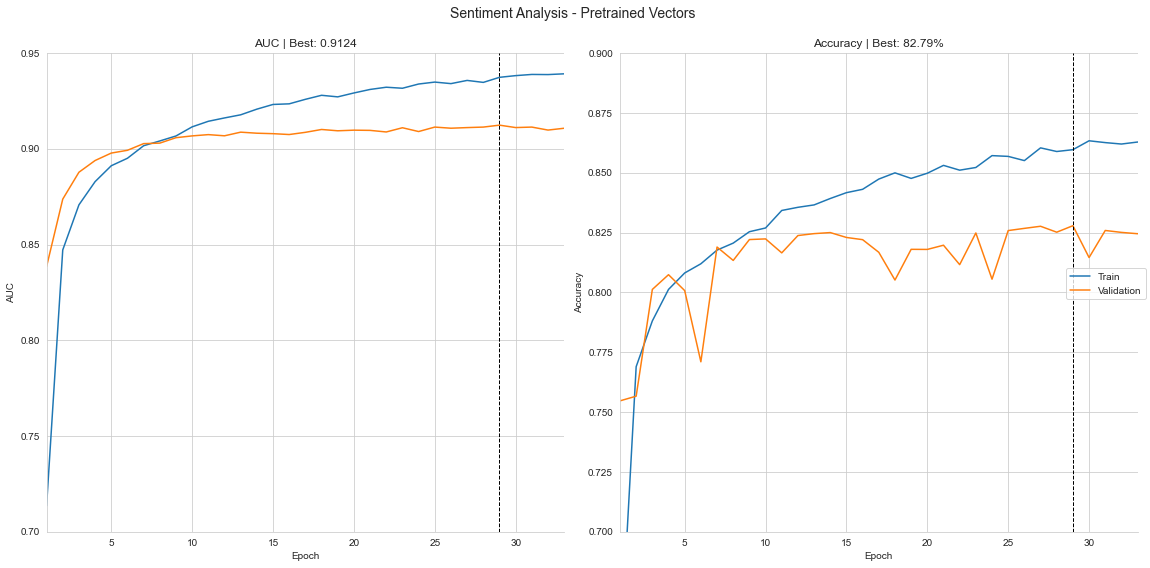

In [16]:
df = pd.DataFrame(training.history)
best_auc = df.val_AUC.max()
best_acc = df.val_accuracy.max()

fig, axes = plt.subplots(ncols=2, figsize=(16,8))
df.index = df.index.to_series().add(1)
df[['AUC', 'val_AUC']].plot(ax=axes[0], title=f'AUC | Best: {best_auc:.4f}', legend=False, xlim=(1, 33),
                            ylim=(.7, .95))

axes[0].axvline(df.val_AUC.idxmax(), ls='--', lw=1, c='k')
df[['accuracy', 'val_accuracy']].plot(ax=axes[1], title=f'Accuracy | Best: {best_acc:.2%}', legend=False,
                                              xlim=(1, 33), ylim=(.7, .9))
axes[1].axvline(df.val_accuracy.idxmax(), ls='--', lw=1, c='k')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('AUC')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
fig.suptitle('Sentiment Analysis - Pretrained Vectors', fontsize=14)
fig.legend(['Train', 'Validation'], loc='center right')

sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig(results_path / 'imdb_pretrained', dpi=300);
# using pretrained word vectors with not trainable MDL(0.9124665056000001) seems not to be the better performance than training own word embeddings MDL(0.9413989215999999)